In [2]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
# import optuna
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics
from downcast import downcast_df

In [3]:
def plot_sample_sim(glm):
    # Prior
    # Plotting distribution of scores simulated from prior
    prior_samples = glm["prior_sim"].prior_predictive.sel(chain=0)
    postrr_samples = glm["postrr_sim"].posterior_predictive.sel(chain=0)
    target = "s"

    # Manipulating samples to plot
    df_prior, na_s = downcast_df(prior_samples[target].to_dataframe().reset_index())
    df_postrr, na_s = downcast_df(postrr_samples[target].to_dataframe().reset_index())

    # Joining rater/topic/model/corpus information
    data1 = data.copy()
    data1[f"{target}_dim_0"] = data1.index
    df_prior1 = pd.merge(df_prior, data1, on=target+"_dim_0", how="left")
    df_postrr1 = pd.merge(df_postrr, data1, on=target+"_dim_0", how="left")

    # Aggregating "1s" and counts by topic
    prior_agg = df_prior1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    postrr_agg = df_postrr1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    obs_agg = df_prior1[df_prior1["chain"]==0].groupby(["draw", "topic_id"]).agg({"intrusion":["sum", "count"]}).reset_index()

    # Calculating topic probabilities from sums and counts
    prior_topic_prob = prior_agg[("s","sum")]/prior_agg[("s","count")]
    postrr_topic_prob = postrr_agg[("s","sum")]/postrr_agg[("s","count")]
    obs_topic_prob = obs_agg[("intrusion","sum")]/obs_agg[("intrusion","count")]

    # Setting up plot
    plot, ax = plt.subplots(1, 1,figsize=(10,6))
    ax = az.plot_kde(np.array(prior_topic_prob), bw=0.05)
    ax.get_lines()[0].set_color("orange")
    ax.get_lines()[0].set_linestyle("--")
    ax = az.plot_kde(np.array(postrr_topic_prob), bw=0.05)
    ax.get_lines()[1].set_color("green")
    ax.get_lines()[1].set_linestyle("--")
    ax = az.plot_kde(np.array(obs_topic_prob), bw=0.05)
    ax.set_title("Prior dist: number of 1's per topic")
    ax.set_ylabel("Density")
    ax.set_xlabel("p")
    ax.legend(ax.get_lines(), ["Prior", "Posterior", "Observed"])

    plt.plot()

In [4]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [5]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordal_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordal_ids["cordal_id"] = cordal_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids.index 

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordal_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordal_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [6]:
# Setting up numpy arrays for pymc
corpora_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

models_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordals_array = np.array(data["cordal_id"])
n_cordals = data["cordal_id"].nunique()

topics_array = np.array(data["topic_id"])
n_topics = data["topic_id"].nunique()

raters_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

scores_array = np.array(data["intrusion"])

## Models

In [8]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}
prior_mean = logit(0.75)

glm_mean = {"model":pm.Model()}
glm_topic = {"model":pm.Model()}
glm_topic_cordal = {"model":pm.Model()} # Cordal contains cross join of corpus and topic 
glm_topic_corpora_model = {"model":pm.Model()}
glm_rater_topic = {"model":pm.Model()}
glm_rater_topic_cordal = {"model":pm.Model()}
glm_rater_model_corpora = {"model":pm.Model()}

In [ ]:
# Topic, cordal model (cordal captures mean)

glm_topic_cordal["model"] = pm.Model()
with glm_topic_cordal["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=2)
    zc = pm.Normal("zc",mu=prior_mean, sigma=0.1, shape=n_corpora)
    sigma_m = pm.Exponential("sigma_m", lam=2)
    zm = pm.Normal("zm",mu=0, sigma=0.1, shape=n_models)
    sigma_a = pm.Exponential("sigma_a", lam=10)
    za = pm.Normal("za",mu=0, sigma=0.1, shape=n_topics)
    
    p = pm.math.invlogit(
        za[topics_array]*sigma_a+
        zc[corpora_array]*sigma_c+
        zm[models_array]*sigma_m)
    s = pm.Bernoulli("s", p=p, observed=scores_array)

    glm_topic_cordal["trace"]=pm.sample(cores=2)

In [52]:
# Rater, Topic and cordal model

glm_rater_topic_cordal["model"] = pm.Model()
with glm_rater_topic_cordal["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=2)
    zc = pm.Normal("zc",mu=prior_mean, sigma=1, shape=n_cordals)
    sigma_r = pm.Exponential("sigma_r", lam=2)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=2)
    za = pm.Normal("za",mu=0, sigma=1, shape=n_topics)
    
    p = pm.math.invlogit(
        za[topics_array]*sigma_a+
        zc[cordals_array]*sigma_c+
        zr[raters_array]*sigma_r)
    s = pm.Bernoulli("s", p=p, observed=scores_array)

    glm_rater_topic_cordal["trace"]=pm.sample(cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_c, zc, sigma_r, zr, sigma_a, za]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 163 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


## Diagnostics

In [53]:
glm = glm_rater_topic_cordal
glm

{'model': sigma_c ~ Exp(f())
      zc ~ N(1.1, 1)
 sigma_r ~ Exp(f())
      zr ~ N(0, 1)
 sigma_a ~ Exp(f())
      za ~ N(0, 1)
       s ~ Bern(f(sigma_r, zr, sigma_c, zc, sigma_a, za)),
 'trace': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'prior_sim': Inference data with groups:
 	> prior
 	> prior_predictive
 	> observed_data,
 'postrr_sim': Inference data with groups:
 	> posterior_predictive
 	> observed_data}

In [54]:
with glm["model"]:
    glm["prior_sim"]=pm.sample_prior_predictive(1_000)
    glm["postrr_sim"]=pm.sample_posterior_predictive(glm["trace"])

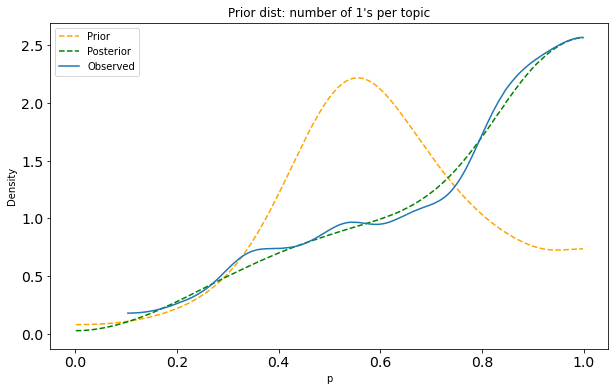

In [55]:
plot_sample_sim(glm)

In [56]:
summary_stat = az.summary(glm["trace"], round_to=4).reset_index()

# Creating parameter and parameter number columns
summary_stat["param"] = summary_stat["index"].str.split("[").str[0]
summary_stat["param_num"] = summary_stat["index"].str.split("[").str[1].str[:-1]
summary_stat["param"] = summary_stat["param"].astype("category")
summary_stat["param_num"] = summary_stat["param_num"].astype("category")
summary_stat = summary_stat[["param", "param_num"]+list(summary_stat.columns[1:-2])]

========================== trace diagnostics ==========================
Divergent transitions
0     9
1    10
dtype: int64


Variable with highest rhat
['za', 171, 1.0154]


Variable with lowest effective sample size
['zc', 1, 252.5057]


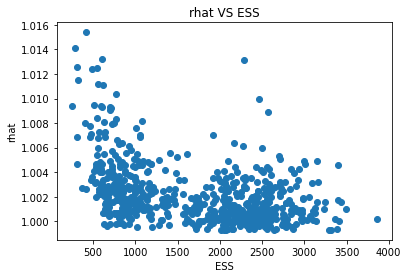

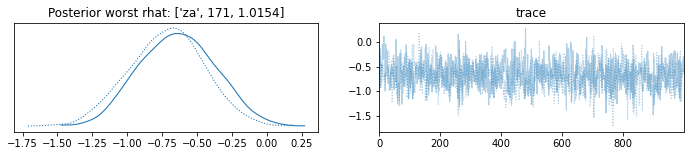

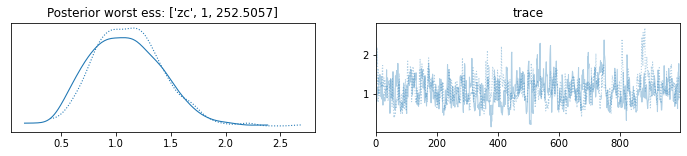

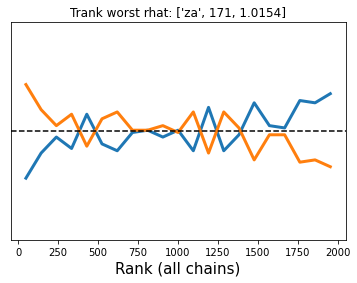

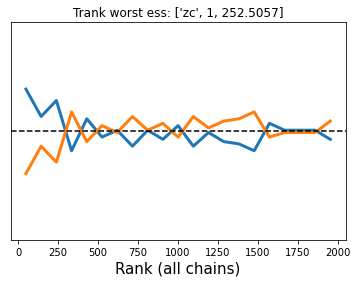

In [57]:
# MCMC Diagnostics

# Selecting parameters with highest rhat and lowest ess
highest_rhat = summary_stat.sort_values(by="r_hat", ascending=False).head(1)
lowest_ess = summary_stat.sort_values(by="ess_bulk", ascending=True).head(1)
# If clause for NaN parameter number
if highest_rhat["param_num"].isna().item():
    highest_rhat = [highest_rhat["param"].item(), None, highest_rhat["r_hat"].item()]
else:
    highest_rhat = [highest_rhat["param"].item(), int(highest_rhat["param_num"].item()), highest_rhat["r_hat"].item()]
    
if lowest_ess["param_num"].isna().item():
    lowest_ess = [lowest_ess["param"].item(), None, lowest_ess["ess_bulk"].item()]
else: 
    lowest_ess = [lowest_ess["param"].item(), int(lowest_ess["param_num"].item()), lowest_ess["ess_bulk"].item()]
    
print("========================== trace diagnostics ==========================")
print("Divergent transitions")
print(pd.DataFrame(glm["trace"].sample_stats["diverging"]).T.sum(axis="rows"))
print("\n")
print("Variable with highest rhat")
print(highest_rhat)
print("\n")
print("Variable with lowest effective sample size")
print(lowest_ess)

# Rhat, ESS scatter
fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.scatter(summary_stat["ess_bulk"], summary_stat["r_hat"])
ax1.set_title("rhat VS ESS")
ax1.set_xlabel("ESS")
ax1.set_ylabel("rhat")

# Trace of worst rhat
if highest_rhat[1] is None: 
    ax3 = az.plot_trace(glm["trace"].posterior[highest_rhat[0]], kind="trace")
else:
    ax3 = az.plot_trace(glm["trace"].posterior[highest_rhat[0]].sel(**{highest_rhat[0]+"_dim_0":highest_rhat[1]}), kind="trace")
ax3[0][0].set_title(f"Posterior worst rhat: {highest_rhat}")
ax3[0][1].set_title("trace")

# Traceof worst ess

if lowest_ess[1] is None: 
    ax4 = az.plot_trace(glm["trace"].posterior[lowest_ess[0]], kind="trace")
else:
    ax4 = az.plot_trace(glm["trace"].posterior[lowest_ess[0]].sel(**{lowest_ess[0]+"_dim_0":lowest_ess[1]}), kind="trace")
ax4[0][0].set_title(f"Posterior worst ess: {lowest_ess}")
ax4[0][1].set_title("trace")

# Trank of worst rhat
if highest_rhat[1] is None: 
    ax5 = az.plot_rank(glm["trace"].posterior[highest_rhat[0]],kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
else:
    ax5 = az.plot_rank(glm["trace"].posterior[highest_rhat[0]].sel(**{highest_rhat[0]+"_dim_0":highest_rhat[1]}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax5.set_title(f"Trank worst rhat: {highest_rhat}")

# Trank of worst ESS
if lowest_ess[1] is None: 
    ax6 = az.plot_rank(glm["trace"].posterior[lowest_ess[0]],kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
else:
    ax6 = az.plot_rank(glm["trace"].posterior[lowest_ess[0]].sel(**{lowest_ess[0]+"_dim_0":lowest_ess[1]}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax6.set_title(f"Trank worst ess: {lowest_ess}")

plt.show()

In [58]:
summary_stat[(summary_stat["param"]!="za") & (summary_stat["param"]!="zr")]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,zc,0,1.9740,0.4368,1.2044,2.7979,0.0228,0.0161,367.0420,737.8982,1.0027
1,zc,1,1.1104,0.3385,0.5157,1.7028,0.0218,0.0158,252.5057,366.4894,1.0094
2,zc,2,1.6312,0.4076,0.9199,2.4070,0.0236,0.0169,315.0043,606.0508,1.0047
3,zc,3,1.9146,0.4421,1.1252,2.7195,0.0256,0.0181,280.5421,456.1334,1.0141
4,zc,4,1.5138,0.4049,0.7394,2.2342,0.0228,0.0162,308.5330,525.1489,1.0126
5,zc,5,1.6582,0.3961,0.9500,2.4322,0.0224,0.0158,316.1671,585.3878,1.0115
627,sigma_c,NaN,0.7911,0.1636,0.5209,1.1091,0.0093,0.0066,308.1551,622.1000,1.0069
628,sigma_r,NaN,0.5094,0.0336,0.4481,0.5761,0.0011,0.0008,924.5467,1325.2171,0.9998
629,sigma_a,NaN,1.3723,0.0661,1.2562,1.5030,0.0033,0.0023,411.0502,778.3727,1.0026


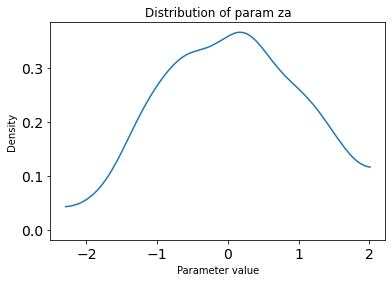

In [68]:
param="za"
ax=az.plot_kde(np.array(summary_stat["mean"][summary_stat["param"]==param]))
ax.set_title(f"Distribution of param {param}")
ax.set_xlabel("Parameter values")
ax.set_ylabel("Density")
plt.show()

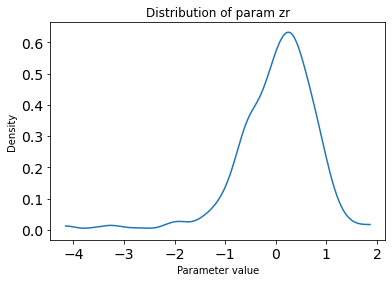

In [69]:
param="zr"
ax=az.plot_kde(np.array(summary_stat["mean"][summary_stat["param"]==param]))
ax.set_title(f"Distribution of param {param}")
ax.set_xlabel("Parameter values")
ax.set_ylabel("Density")
plt.show()

In [ ]:
# Plot trace of parameter
param = "sigma_a"
param_num = None

# Trace
if param_num is None: 
    ax1 = az.plot_trace(glm["trace"].posterior[param], kind="trace")
else:
    ax1 = az.plot_trace(glm["trace"].posterior[param].sel(**{param+"_dim_0":param_num}), kind="trace")
ax1[0][0].set_title(f"Posterior {param}")
ax1[0][1].set_title("Trace")

# Trank
if param_num is None: 
    ax2 = az.plot_rank(glm["trace"].posterior[param],kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
else:
    ax2 = az.plot_rank(glm["trace"].posterior[param].sel(**{param+"_dim_0":param_num}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax2.set_title(f"Trank {param}")

plt.show()